**About Dataset**

Introduction
Tornadoes frequently occur in the United States, resulting in vast destruction and often injuries and death. They occur more often in the United States and Canada than in other countries with the most tornado-prone regions in the US being the central and southeastern states along a corridor sometimes called "Tornado Alley."

A tornado's destructiveness is derived largely from the wind speed within it. For this reason, meteoroligists rate tornadoes using a scale based on wind speed. In the US, tornadoes were originally rated on the Fujita Scale, and since February 2007 on the Enhanced Fujita Scale. The two scales cover slightly different speed ranges, but for practical purposes are the same. The enhanced Fujita scale is shown below.


**The Enhance Fujita Scale**

Rating	 Wind-Speed	   Damage

EF0	     65–85 mph	   Light damage

EF1	     86–110 mph	   Moderate damage

EF2	     111–135 mph	 Considerable damage

EF3	     136–165 mph	 Severe damage

EF4	     166–200 mph	 Devastating damage

EF5	     >200 mph	     Incredible damage


**Origin**

This dataset was derived from a dataset produced by NOAA's Storm Prediction Center. The primary changes made to create this dataset were the deletion of some columns, change of some data types, and sorting by date.


**Column Definitions**

Year - 4-digit year

Month - Month (1-12)

Day - Day of month

Date - Datetime object (e.g. 1950-01-01)

State - State where tornado originated; 2-digit abbreviation

magMagnitude on F/EF scale - F rating thru Jan 2007; EF rating after Jan 2007 (-9 if unknown rating)

Number of injuries - Number of injuries

Number of fatalities - Number of fatalities

Starting latitude - Starting latitude in decimal degrees

Starting longitude - Starting longitude in decimal degrees

Ending latitude - Ending latitude in decimal degrees (value of 0 if missing)

Ending longitude - Ending longitude in decimal degrees (value of 0 if missing)

Track length in KM - Length of track in kilo meters

Tornado width in meters - Width in meters

Starting location - starting location details

Ending location - ending location details

# Imports

In [ ]:
import pandas as pd
import networkx as nx
import community
import ast
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="tornados")
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

# Support Functions

## Convert the string tuple to regular tuple.

In [ ]:
# Convert tuple string to a tuple "(1,2)" -> (1,2)
def convertTupleStrToTuple(tuple_string):
  return ast.literal_eval(tuple_string)

## Get edge data

In [ ]:
# Get edge data
def getEdgeData(source, target, G):
    # Get the edge data for the specified edge
  edge_data = G.get_edge_data(source, target)

  # Check if the edge exists
  if edge_data is not None:
      # Access the edge attributes
      edgeStr = f"{source} -> {target}"
      trackedLenghtKM = edge_data['trackedLenghtKM']
      numOfInjuries = edge_data['numOfInjuries']
      numOfFatalities = edge_data['numOfFatalities']
      efScaleAVG = edge_data['efScaleAVG']
      widthInMetersAVG = edge_data['widthInMetersAVG']
      edgeCount = edge_data['edgeCount']
      return edgeStr, trackedLenghtKM, numOfInjuries, numOfFatalities, efScaleAVG, widthInMetersAVG, edgeCount
  else:
      return 0

## Calculate node in and out degrees

In [ ]:
# calculate in/out degree by measure represented numeric edge attribute
def calcInandOutDegByMeasure(G, measure, topN=5):
  # Calculate the indegree and outdegree based on edge weights that represent Tracked lenght in KM
  indegree = {}
  outdegree = {}

  for u, v, data in G.edges(data=True):
      # Get the weight of the edge by measure
      weight = data.get(measure, 1)  # Assuming weight attribute exists, default to 1 if not present

      # Update the indegree and outdegree dictionaries
      outdegree[u] = outdegree.get(u, 0) + weight
      indegree[v] = indegree.get(v, 0) + weight
  # returns (topN indegree by measure), (topN outdegree by measure)
  return sorted(indegree,key=indegree.get, reverse=True )[:topN], sorted(outdegree,key=outdegree.get, reverse=True )[:topN]

## Initialize the graph

In [ ]:
# Create a graph represent a network of tornados
def initGraph(df):
  # Create an empty directed graph
  G = nx.DiGraph()

  # count_rows = 0
  # for row in df.iterrows():

  # Iterate over the selected_df rows
  for _, row in df.iterrows():
      starting_point = row['Starting coordinate round']
      ending_point = row['Ending coordinate round']
      trackedLenghtKM = row['Track length in KM']
      numOfInjuries = row['Number of injuries']
      numOfFatalities = row['Number of fatalities']
      edgeCount = 1
      #===== need different calculation - mean
      efScaleAVG = row['Magnitude on F/EF scale']
      widthInMetersAVG = row['Tornado width in meters']

      # Check if the edge already exists in the network
      if G.has_edge(starting_point, ending_point):
        # Retrieve the existing attribute values
        existing_data = G.get_edge_data(starting_point, ending_point)

        # Add the new values to the existing values
        trackedLenghtKM += existing_data['trackedLenghtKM']
        numOfInjuries += existing_data['numOfInjuries']
        numOfFatalities += existing_data['numOfFatalities']
        edgeCount += existing_data['edgeCount']
        #===== need different calculation - mean
        efScaleAVG +=  existing_data['efScaleAVG']
        widthInMetersAVG += existing_data['widthInMetersAVG']

      # Add the edge with the updated attribute values
      G.add_edge(starting_point, ending_point, trackedLenghtKM=trackedLenghtKM, numOfInjuries=numOfInjuries, numOfFatalities=numOfFatalities, efScaleAVG=efScaleAVG, widthInMetersAVG=widthInMetersAVG, edgeCount=edgeCount)

  # Override efScaleAVG and widthInMetersAVG with edgeCount/efScaleAVG and edgeCount/widthInMetersAVG
  for starting_point, ending_point, attributes in G.edges(data=True):
      attributes['efScaleAVG'] = attributes['efScaleAVG'] / attributes['edgeCount']
      attributes['widthInMetersAVG'] = attributes['widthInMetersAVG'] / attributes['edgeCount']

  return G

##Sort Data Frame


In [ ]:
def sort_dataframe(df, column):
    sorted_df = df.sort_values(by=column, ascending=False)
    return sorted_df


# Read csv and create the decade network

In [ ]:
#tornados_df = pd.read_csv('./Tornados_cleaned.csv')

In [ ]:
# Need to mount google drive if not mounted. please select "Connect to google drive" -> choose your acount -> Allow
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
file_id = '1BGa9m2ICrpMkIXbPkba2dg7FdPtBz7j0'
link = f'https://drive.google.com/uc?id={file_id}'
tornados_df = pd.read_csv(link)

In [ ]:
# Specify the range of years
start_year = 2011
end_year = 2021

# Create a new DataFrame with rows between the specified range
selected_df = tornados_df[(tornados_df['Year'] >= start_year) & (tornados_df['Year'] <= end_year)].copy()


In [ ]:
# Drop Unnecessary columns
selected_df = selected_df.drop(['Unnamed: 0','Day of Month','Date'], axis=1)

Rounding the coordinates so that a node is derived by 1 unit of longitude\latitude. One unit of those is approximately 100km.

In [ ]:
# Create 'Starting coordinate round' column
selected_df["Starting coordinate round"] = selected_df.apply(
    lambda row: f"({round(row['Starting latitude'], 0)},{round(row['Starting longitude'], 0)})", axis=1)

# Create 'Ending coordinate round' column
selected_df["Ending coordinate round"] = selected_df.apply(
    lambda row: f"({round(row['Ending latitude'], 0)},{round(row['Ending longitude'], 0)})", axis=1)


We found that there is a location in (0,0) in the data which in not in the US, so we dropped it.

In [ ]:
selected_df = selected_df[selected_df['Starting latitude'] != 0]
selected_df = selected_df[selected_df['Starting longitude'] != 0]
selected_df = selected_df[selected_df['Ending longitude'] != 0]
selected_df = selected_df[selected_df['Ending longitude'] != 0]

In [ ]:
pair_counts = selected_df.groupby(["Starting coordinate round", "Ending coordinate round"]).size().reset_index(name="Count")

In [ ]:
selected_df.head()

,Year,Month,State,Magnitude on F/EF scale,Number of injuries,Number of fatalities,Starting latitude,Starting longitude,Ending latitude,Ending longitude,Track length in KM,Tornado width in meters,Starting location,Ending location,Starting coordinate round,Ending coordinate round
12697,2011,1,MS,1,0,0,33.2839,-89.2400,33.2842,-89.1271,10.49,68.58,", ,Choctaw County,Mississippi,","Choctaw Lake Road, ,Choctaw County,Mississippi,","(33.0,-89.0)","(33.0,-89.0)"
12698,2011,1,MS,1,0,0,32.6646,-88.8355,32.7495,-88.6743,17.80,402.34,"Smith-Galloway Road,Damascus,Kemper County,Mis...","Billy Calvert Road, ,Kemper County,Mississippi...","(33.0,-89.0)","(33.0,-89.0)"
12699,2011,1,MS,2,0,0,32.9012,-88.7666,32.9368,-88.6710,9.77,786.38,", ,Kemper County,Mississippi,",",Fairhill,Noxubee County,Mississippi,","(33.0,-89.0)","(33.0,-89.0)"
12700,2011,1,MS,3,2,0,33.0394,-89.8123,33.2213,-89.4700,37.74,1188.72,"County Road 4112, ,Attala County,Mississippi,3...","County Road 2277, ,Attala County,Mississippi,","(33.0,-90.0)","(33.0,-89.0)"
12701,2011,1,MS,3,1,0,33.0609,-88.4640,33.1484,-88.3345,15.50,1216.15,"East Spann Road, ,Noxubee County,Mississippi,","Prairie Point Road,Aubrey,Noxubee County,Missi...","(33.0,-88.0)","(33.0,-88.0)"


In [ ]:
selected_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4216 entries, 12697 to 16912
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Year                       4216 non-null   int64  
 1   Month                      4216 non-null   int64  
 2   State                      4216 non-null   object 
 3   Magnitude on F/EF scale    4216 non-null   int64  
 4   Number of injuries         4216 non-null   int64  
 5   Number of fatalities       4216 non-null   int64  
 6   Starting latitude          4216 non-null   float64
 7   Starting longitude         4216 non-null   float64
 8   Ending latitude            4216 non-null   float64
 9   Ending longitude           4216 non-null   float64
 10  Track length in KM         4216 non-null   float64
 11  Tornado width in meters    4216 non-null   float64
 12  Starting location          4216 non-null   object 
 13  Ending location            4216 non-null   

In [ ]:
G = initGraph(selected_df)

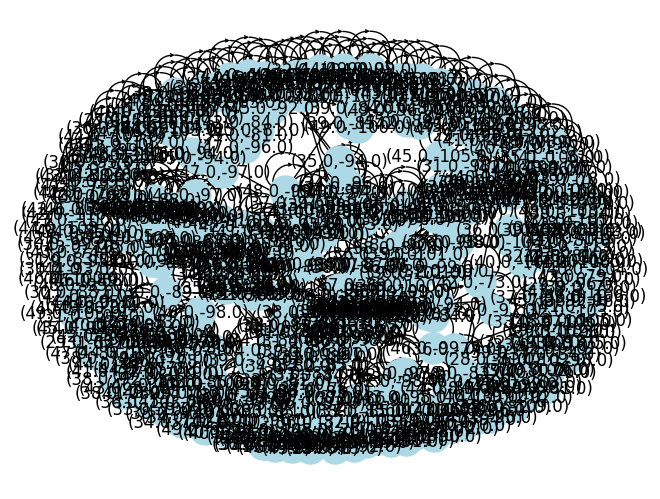

In [ ]:
pos = nx.spring_layout(G)  # Layout algorithm
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, arrowstyle='->', arrowsize=5)

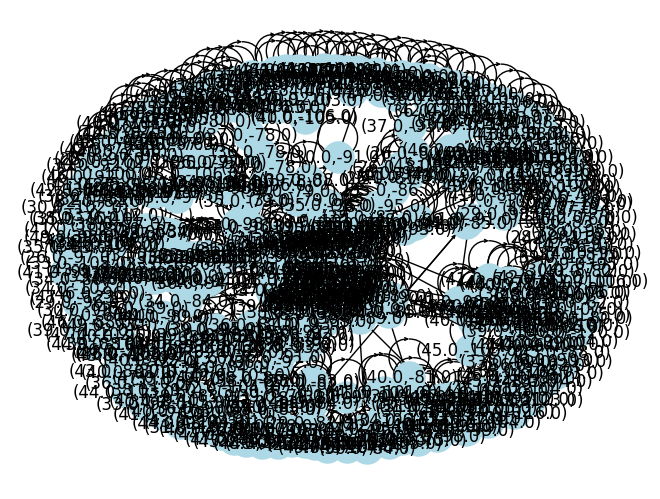

In [ ]:
# Draw the graph
pos = nx.spring_layout(G)  # Layout algorithm
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, arrowstyle='->', arrowsize=5)

# Add labels for edge attributes
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# Show the plot
plt.show()


# First nodes analysis

For a start, we want to locate the areas that tornados are most likely to start and end regardless of their EF scale, tracked length or any other measures.

In [ ]:
# Calculate the indegree centrality
indegree_centrality = nx.in_degree_centrality(G)

# Sort nodes based on indegree centrality and get the top n nodes
top_indegree_nodes = sorted(indegree_centrality, key=indegree_centrality.get, reverse=True)[:5]

# Calculate the outdegree centrality
outdegree_centrality = nx.out_degree_centrality(G)

# Sort nodes based on outdegree centrality and get the top n nodes
top_outdegree_nodes = sorted(outdegree_centrality, key=outdegree_centrality.get, reverse=True)[:5]

# Print the top nodes with highest indegree and outdegree values
print("Top nodes with highest indegree:")
for node in top_indegree_nodes:
    print(node, "Indegree:", indegree_centrality[node])

print("\nTop nodes with highest outdegree:")
for node in top_outdegree_nodes:
    print(node, "Outdegree:", outdegree_centrality[node])


Top nodes with highest indegree:
(33.0,-89.0) Indegree: 0.0073937153419593345
(33.0,-88.0) Indegree: 0.0073937153419593345
(36.0,-87.0) Indegree: 0.0073937153419593345
(36.0,-86.0) Indegree: 0.0073937153419593345
(35.0,-86.0) Indegree: 0.0073937153419593345

Top nodes with highest outdegree:
(33.0,-88.0) Outdegree: 0.009242144177449167
(32.0,-90.0) Outdegree: 0.009242144177449167
(36.0,-89.0) Outdegree: 0.009242144177449167
(37.0,-89.0) Outdegree: 0.0073937153419593345
(35.0,-94.0) Outdegree: 0.0073937153419593345


In [ ]:
# converting the strings back to touples
top_indegree_nodes_converted = [convertTupleStrToTuple(n) for n in top_indegree_nodes]
top_outdegree_nodes_converted = [convertTupleStrToTuple(n) for n in top_outdegree_nodes]

In [ ]:
print('----InDegree Locations----')
for n in top_indegree_nodes_converted:
  print(geolocator.reverse(f"{n[0]}, {n[1]}"))
print('----OutDegree Locations----')
for n in top_outdegree_nodes_converted:
  print(geolocator.reverse(f"{n[0]}, {n[1]}"))

----InDegree Locations----
1822, Enon Road, Winston County, Mississippi, 39339, United States
Greene County, Alabama, United States
Williamson County, Middle Tennessee, Tennessee, United States
Preston Vickers Road, DeKalb County, Tennessee, 37095, United States
Poplar Springs Road, Lakeview, Franklin County, Tennessee, United States
----OutDegree Locations----
Greene County, Alabama, United States
South Ash Drive, Simpson County, Mississippi, 39044, United States
133, Sam Gannaway Road, Gibson County, West Tennessee, Tennessee, 38382, United States
Beno Wells Lane, Ballard County, Kentucky, 42087, United States
Roadrunner Trail, Scott County, Arkansas, United States


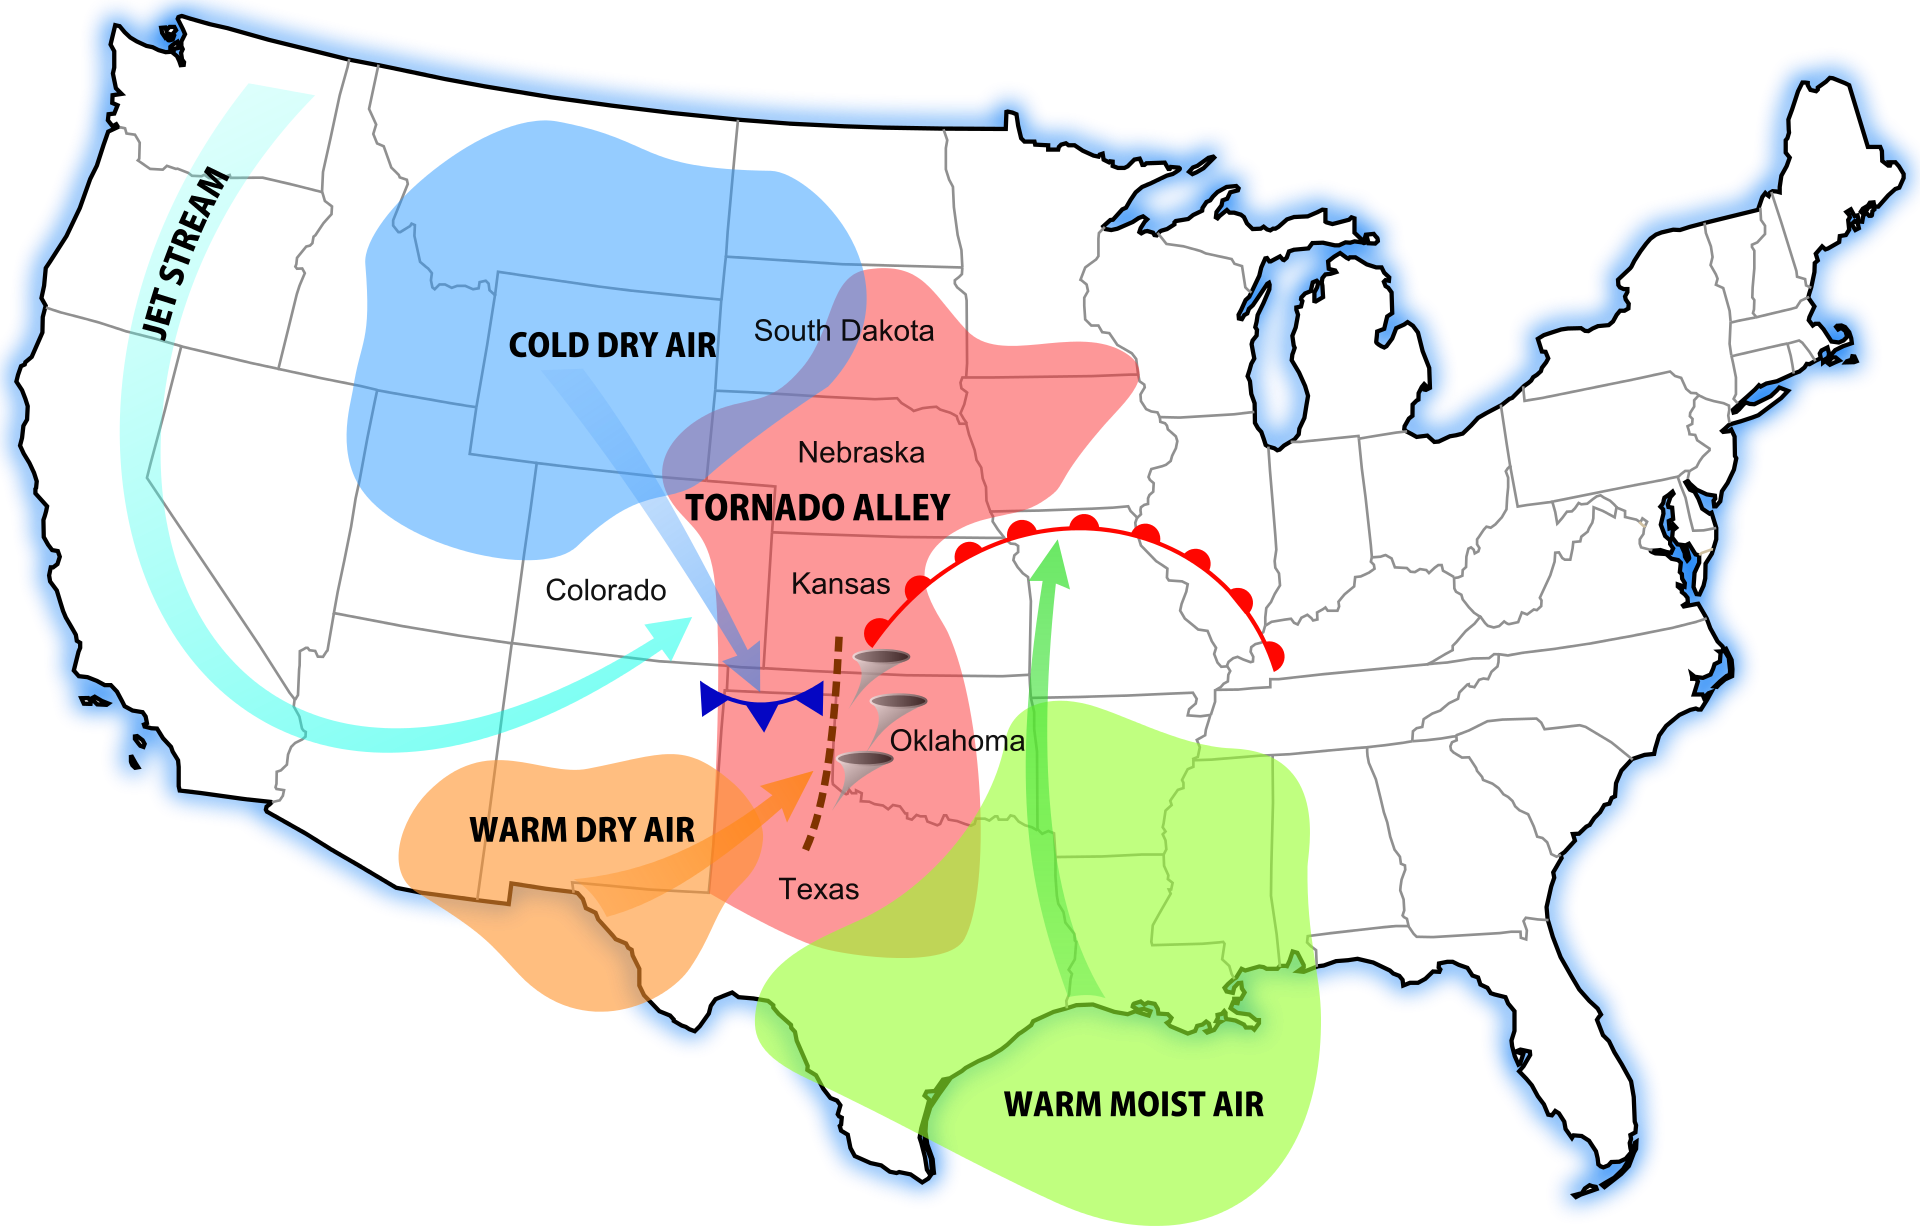


When looking at the top 5 nodes with the highest in degree and the top 5 nodes with the highest out degree it appears that those areas are not necessarily close to each other. However we can see the repeated appearance of Mississippi and Illinois. According to Wikipedia those two countries are apart of 17 countries with the highest average number of EF0-EF5 tornadoes per 10,000 square miles (25,899.9 km2) per year (https://en.wikipedia.org/wiki/Tornado_Alley) between 1991 to 2010. Although the current network is between 1950 to 1961 we expect to see a direction of changes in the network.

In [ ]:
tornadoAlleyCountries = ['Florida', 'Kansas', 'Maryland', 'Illinois', 'Mississippi', 'Iowa', 'Oklahoma', 'South Carolina', 'Alabama', 'Louisiana', 'Arkansas', 'Nebraska', 'Missouri', 'North Carolina', 'Tennessee', 'Indiana', 'Texas']

Finding the top 5 nodes with the highest in and out degree based on the tornado's track length.


In [ ]:
indegree_by_lenght, outdegree_by_lengh = calcInandOutDegByMeasure(G, 'trackedLenghtKM')
indegree_by_lenght_converted = [convertTupleStrToTuple(n) for n in indegree_by_lenght]
outdegree_by_lengh_converted = [convertTupleStrToTuple(n) for n in outdegree_by_lengh]

In [ ]:
print("Top nodes with highest indegree by tracked lenght:")
for n in indegree_by_lenght:
  print(n)
print("Top nodes with highest outdegree by tracked lenght:")
for n in outdegree_by_lengh:
  print(n)

Top nodes with highest indegree by tracked lenght:
(35.0,-86.0)
(34.0,-86.0)
(33.0,-87.0)
(32.0,-90.0)
(32.0,-89.0)
Top nodes with highest outdegree by tracked lenght:
(33.0,-88.0)
(32.0,-90.0)
(33.0,-89.0)
(34.0,-87.0)
(33.0,-87.0)


In [ ]:
print('----InDegree Locations by Tracked lenght in KM----')
for n in indegree_by_lenght_converted:
  print(geolocator.reverse(f"{n[0]}, {n[1]}"))
print('----OutDegree Locations by Tracked lenght in KM----')
for n in outdegree_by_lengh_converted:
  print(geolocator.reverse(f"{n[0]}, {n[1]}"))

----InDegree Locations by Tracked lenght in KM----
Poplar Springs Road, Lakeview, Franklin County, Tennessee, United States
Gadsden, Etowah County, Alabama, 35901, United States
Six Mile Run, Sixmile, Bibb County, Alabama, United States
South Ash Drive, Simpson County, Mississippi, 39044, United States
County Road 39, Jasper County, Mississippi, 39348, United States
----OutDegree Locations by Tracked lenght in KM----
Greene County, Alabama, United States
South Ash Drive, Simpson County, Mississippi, 39044, United States
1822, Enon Road, Winston County, Mississippi, 39339, United States
County Road 108, Brushy Pond, Cullman County, Alabama, 35033, United States
Six Mile Run, Sixmile, Bibb County, Alabama, United States


In [ ]:
indegree_intersection = list(set(top_indegree_nodes) & set(indegree_by_lenght))
outdegree_intersection = list(set(top_outdegree_nodes) & set(outdegree_by_lengh))

print('intersection of indegree by number of neighbors and sum of the tracked lenght', indegree_intersection)
print('intersection of outdegree by number of neighbors and sum of the tracked lenght', outdegree_intersection)

intersection of indegree by number of neighbors and sum of the tracked lenght ['(35.0,-86.0)']
intersection of outdegree by number of neighbors and sum of the tracked lenght ['(32.0,-90.0)', '(33.0,-88.0)']


In [ ]:
print("num of indegree's neighbors")
for n in indegree_intersection:
  print(len(list(G.neighbors(n))))

print("num of outdegree's neighbors")
for n in outdegree_intersection:
  print(len(list(G.neighbors(n))))


num of indegree's neighbors
3
num of outdegree's neighbors
5
5


By intersection the 2 lists of indegree and the 2 lists of the outdegree we can see that there are common nodes in the network (represented rounded coordinates). Not only they are defined as areas that a tornado is most likely to start or to end, but the tracks' lengths of those tornados will most likely be long.

# **Edge centrality measures that we are going to calculate**

1. Edge Closeness Centrality: Measures how close an edge is to other edges in the network. It calculates the average shortest path length between a given edge and all other edges in the network. Therefore, in our network, if an edge gets a high score of this measure, it means that the tornado location is surrounded with many more tornados around it in this decade.

2. Edge Degree Centrality: Measures the number of edges that are directly connected to a given edge. It provides a measure of how connected an edge is within the network. Therefore, in our network, if an edge gets a high score of this measure, it means that the tornado's location of start/end is a common location for other tornados to start/end.

3. Edge Eigenvector Centrality: Assigns a score to each edge based on the centrality of its neighboring edges. It takes into account both the number and importance of neighboring edges. Therefore, in our network, if an edge gets a high score of this measure, it means that it's surrounded by many other central tornados.

4. Edge Betweeness Centrality: Edge betweenness centrality is a measure that assesses how often an edge lies on the shortest path between pairs of nodes in the network. Edges with higher betweenness centrality are considered more critical in facilitating communication and information flow between different parts of the network.



Creating a new data frame with unique edges only, in order to display the measures we detailed above. The new df will have the following columns:

1 - Edge - has both starting coorsinate and ending coordinate.

2 - Source - starting coordinate.

3 - Target - Ending coordinate.

4 - Tracked length KM - the sum of the track of all the tornados from the same
starting point to the same ending point.

5 - Number of injuries - the sum of the injuries of all the tornados from the same starting point to the same ending point.

6 - Number of fatalities - the sum of the fatalities of all the tornados from the same starting point to the same ending point.

7 - EF scale (AVG) - the average of the magnitudes of all the tornados from the same starting point to the same ending point.

8 - Width in Meters (AVG) - the average of the widths of all the tornados from the same starting point to the same ending point.

9 - Edge count - the sum of all the tornados from the same starting point to the same ending point.

In [ ]:
# Create a new DataFrame
df_edges = pd.DataFrame(columns=['Edge', 'Source', 'Target', 'Tracked Length (KM)', 'Number of Injuries', 'Number of Fatalities',
                                 'EF Scale (AVG)', 'Width in Meters (AVG)', 'Edge Count'])

# Iterate over all the edges in the graph
for source, target in G.edges:
    # Get the edge data using the getEdgeData function
    edge_data = getEdgeData(source, target, G)

    # Check if the edge data is not 0 (i.e., the edge exists)
    if edge_data != 0:
        # Assign the values to new columns in the DataFrame
        df_edges = df_edges.append({'Edge': edge_data[0],
                                    'Source': source,
                                    'Target': target,
                                    'Tracked Length (KM)': edge_data[1],
                                    'Number of Injuries': edge_data[2],
                                    'Number of Fatalities': edge_data[3],
                                    'EF Scale (AVG)': edge_data[4],
                                    'Width in Meters (AVG)': edge_data[5],
                                    'Edge Count': edge_data[6]}, ignore_index=True)

df_edges['Number of Injuries'] = df_edges['Number of Injuries'].astype(int)
df_edges['Number of Fatalities'] = df_edges['Number of Fatalities'].astype(int)


# Display the new DataFrame
df_edges.head()


,Edge,Source,Target,Tracked Length (KM),Number of Injuries,Number of Fatalities,EF Scale (AVG),Width in Meters (AVG),Edge Count
0,"(33.0,-89.0) -> (33.0,-89.0)","(33.0,-89.0)","(33.0,-89.0)",461.38,92,13,1.194444,514.934167,36
1,"(33.0,-89.0) -> (33.0,-88.0)","(33.0,-89.0)","(33.0,-88.0)",343.76,14,1,2.000000,811.783333,9
2,"(33.0,-89.0) -> (34.0,-89.0)","(33.0,-89.0)","(34.0,-89.0)",129.21,25,0,1.333333,624.840000,3
3,"(33.0,-90.0) -> (33.0,-89.0)","(33.0,-90.0)","(33.0,-89.0)",127.27,2,0,1.428571,949.668571,7
4,"(33.0,-90.0) -> (33.0,-90.0)","(33.0,-90.0)","(33.0,-90.0)",558.38,6,1,1.179487,591.405128,39


In [ ]:
# Create an empty list for edge centrality measures
edge_closeness_list = []
edge_betweenness_list = []
edge_eigenvector_list = []
edge_degree_list = []

# Calculate the centrality measures for the graph
closeness_centrality = nx.closeness_centrality(G)
betweenness_centrality = nx.edge_betweenness_centrality(G)
eigenvector_centrality = nx.eigenvector_centrality_numpy(G)
degree_centrality = G.degree()

# Iterate over all the edges in the graph
for source, target in G.edges:
    # Calculate the average closeness centrality of the nodes in the edge
    closeness_source = closeness_centrality[source]
    closeness_target = closeness_centrality[target]
    edge_closeness = (closeness_source + closeness_target) / 2

    # Append the edge closeness centrality to the list
    edge_closeness_list.append(edge_closeness)

    # Calculate the edge betweenness centrality
    edge_betweenness = betweenness_centrality[(source, target)]

    # Append the edge betweenness centrality to the list
    edge_betweenness_list.append(edge_betweenness)

    # Calculate the edge eigenvector centrality as the sum of the eigenvector values of its nodes
    edge_eigenvector = eigenvector_centrality[source] + eigenvector_centrality[target]

    # Append the edge eigenvector centrality to the list
    edge_eigenvector_list.append(edge_eigenvector)

    # Get the edge degree
    edge_degree_source = degree_centrality[source] - 1 if source == target else degree_centrality[source]
    edge_degree_target = degree_centrality[target] - 1 if target == source else degree_centrality[target]

    # Append the edge degree to the list
    edge_degree_list.append(edge_degree_source + edge_degree_target)

# Add the 'Edge Closeness' column to df_edges
df_edges['Edge Closeness'] = edge_closeness_list
# Add the 'Edge Betweenness' column to df_edges
df_edges['Edge Betweenness'] = edge_betweenness_list
# Add the 'Eigenvector' column to df_edges
df_edges['Eigenvector'] = edge_eigenvector_list
# Add the 'Edge Degree' column to df_edges
df_edges['Edge Degree'] = edge_degree_list


#We want to see the connection between the network measures and the Tornado Alley

In [ ]:
# Extract state names from 'Starting location' column in selected_df
selected_df['Source State'] = selected_df['Starting location'].apply(lambda x: x.split(',')[3].strip() if len(x) >= 4 else '')

# Extract state names from 'Ending location' column in selected_df
selected_df['Target State'] = selected_df['Ending location'].apply(lambda x: x.split(',')[3].strip() if len(x) >= 4 else '')

# Create a mapping dictionary for state names
state_mapping = selected_df[['Starting coordinate round', 'Source State']].drop_duplicates().set_index('Starting coordinate round')['Source State'].to_dict()

# Map the state names to df_edges based on the source coordinates
df_edges['Source State'] = df_edges['Source'].map(state_mapping)

# Create a mapping dictionary for target state names
state_mapping = selected_df[['Ending coordinate round', 'Target State']].drop_duplicates().set_index('Ending coordinate round')['Target State'].to_dict()

# Map the state names to df_edges based on the target coordinates
df_edges['Target State'] = df_edges['Target'].map(state_mapping)


Mapping each cordinates to a state

In [ ]:
# Check the number of unique values in 'Source State' column
num_unique_source_states = df_edges['Source State'].nunique()
print("Number of unique source states:", num_unique_source_states)

# Check the number of unique values in 'Target State' column
num_unique_target_states = df_edges['Target State'].nunique()
print("Number of unique target states:", num_unique_target_states)


Number of unique source states: 44
Number of unique target states: 46


Create 'Is Tornado Alley' column and set to true if both source and target are states that belongs to the Tornado Alley

In [ ]:
df_edges['Is Tornado Alley'] = (df_edges['Source State'].isin(tornadoAlleyCountries)) & (df_edges['Target State'].isin(tornadoAlleyCountries)).astype(int)

In [ ]:
df_edges.head()

,Edge,Source,Target,Tracked Length (KM),Number of Injuries,Number of Fatalities,EF Scale (AVG),Width in Meters (AVG),Edge Count,Edge Closeness,Edge Betweenness,Eigenvector,Edge Degree,Source State,Target State,Is Tornado Alley
0,"(33.0,-89.0) -> (33.0,-89.0)","(33.0,-89.0)","(33.0,-89.0)",461.38,92,13,1.194444,514.934167,36,0.012015,0.000000,7.922182e-10,12,Mississippi,Mississippi,True
1,"(33.0,-89.0) -> (33.0,-88.0)","(33.0,-89.0)","(33.0,-88.0)",343.76,14,1,2.000000,811.783333,9,0.011669,0.000746,1.582271e-09,16,Mississippi,Alabama,True
2,"(33.0,-89.0) -> (34.0,-89.0)","(33.0,-89.0)","(34.0,-89.0)",129.21,25,0,1.333333,624.840000,3,0.012891,0.000318,7.941661e-10,13,Mississippi,Mississippi,True
3,"(33.0,-90.0) -> (33.0,-89.0)","(33.0,-90.0)","(33.0,-89.0)",127.27,2,0,1.428571,949.668571,7,0.010340,0.000541,3.969753e-10,13,Mississippi,Mississippi,True
4,"(33.0,-90.0) -> (33.0,-90.0)","(33.0,-90.0)","(33.0,-90.0)",558.38,6,1,1.179487,591.405128,39,0.008666,0.000000,1.732353e-12,10,Mississippi,Mississippi,True


## Getting the top 10 edges for every measure

In [ ]:
# Get the top 10 edges for every measure

# Create an empty dictionary for each centrality measure
top_10_edges = {
    'Edge Closeness': [],
    'Edge Betweenness': [],
    'Eigenvector': [],
    'Edge Degree': []
}

# Iterate over each centrality measure
for measure_name, measure_list in top_10_edges.items():
    # Sort the edges based on the measure in descending order
    sorted_edges = sorted(zip(df_edges['Edge'], df_edges[measure_name]), key=lambda x: x[1], reverse=True)

    # Select the top 10 edges with the highest measure
    top_10 = sorted_edges[:10]

    # Append the edges and measures to the corresponding measure list
    measure_list.extend(top_10)

    # Print the top 10 edges and their corresponding measure
    print(f"Top 10 Edges based on {measure_name}:")
    for edge, measure in top_10:
        print(f"Edge: {edge}, Measure: {measure}")
    print()



Top 10 Edges based on Edge Closeness:
Edge: (38.0,-87.0) -> (38.0,-87.0), Measure: 0.021893395890537896
Edge: (37.0,-87.0) -> (38.0,-87.0), Measure: 0.02133465181021474
Edge: (36.0,-86.0) -> (36.0,-86.0), Measure: 0.020968114602587802
Edge: (37.0,-87.0) -> (37.0,-87.0), Measure: 0.020775907729891577
Edge: (38.0,-87.0) -> (38.0,-86.0), Measure: 0.020507251564178333
Edge: (36.0,-87.0) -> (36.0,-86.0), Measure: 0.02026985701859302
Edge: (36.0,-87.0) -> (37.0,-87.0), Measure: 0.020173753582244908
Edge: (39.0,-84.0) -> (39.0,-84.0), Measure: 0.020013655826379567
Edge: (36.0,-87.0) -> (36.0,-87.0), Measure: 0.01957159943459824
Edge: (36.0,-86.0) -> (36.0,-85.0), Measure: 0.019551350102412948

Top 10 Edges based on Edge Betweenness:
Edge: (36.0,-92.0) -> (36.0,-91.0), Measure: 0.0026302003475570344
Edge: (35.0,-93.0) -> (36.0,-92.0), Measure: 0.002230829874359952
Edge: (39.0,-89.0) -> (40.0,-88.0), Measure: 0.0020053065595350963
Edge: (36.0,-91.0) -> (36.0,-89.0), Measure: 0.00198329870859577

A very small eigenvector centrality value for an edge in a network, typically indicates that the edge has low importance or influence within the network. Eigenvector centrality measures the importance of a node or edge in relation to the importance of its neighboring nodes. A small eigenvector centrality value suggests that the edge is not well connected to important or highly central nodes in the network.

Here are a few possible interpretations of a small eigenvector centrality value for the edges:

Low Connectivity: The edge may have fewer connections to other nodes compared to other edges in the network. It could have relatively fewer neighboring nodes, resulting in a lower eigenvector centrality value.

Limited Influence: The edge may not play a significant role in connecting or transmitting information between important or central nodes. It might have minimal impact on the flow of information, interactions, or influence within the network.

## Calculating the intersections of the measures

Calculating the intersections in order to detect the common locations of the starting points or ending points of the tornados.

In [ ]:
# Create a list for each centrality measure to store the edge values
edge_closeness_list = [edge for edge, _ in top_10_edges['Edge Closeness']]
edge_betweeness_list = [edge for edge, _ in top_10_edges['Edge Betweenness']]
eigenvector_list = [edge for edge, _ in top_10_edges['Eigenvector']]
edge_degree_list = [edge for edge, _ in top_10_edges['Edge Degree']]

# Calculate the intersection of the lists
intersection = set(edge_closeness_list) & set(edge_betweeness_list) & set(eigenvector_list) & set(edge_degree_list)

intersection_1 = set(edge_betweeness_list) & set(eigenvector_list)
intersection_2 = set(edge_closeness_list) & set(eigenvector_list)
intersection_3 = set(edge_degree_list) & set(eigenvector_list)

intersection_4 = set(edge_betweeness_list) & set(edge_degree_list)
intersection_5 = set(edge_betweeness_list) & set(edge_closeness_list)
intersection_6 = set(edge_degree_list) & set(edge_closeness_list)


# Print the common edges across all measures
print("Edges in the intersection of all measures:")
for edge in intersection:
    print(edge)

print("Edges in the intersection edge betweeness & eigenvector:")
for edge in intersection_1:
    print(edge)

print("Edges in the intersection edge closeness & eigenvector:")
for edge in intersection_2:
    print(edge)

print("Edges in the intersection edge degree & eigenvector:")
for edge in intersection_3:
    print(edge)

print("Edges in the intersection edge betweeness & degree:")
for edge in intersection_4:
    print(edge)

print("Edges in the intersection edge betweeness & closeness:")
for edge in intersection_5:
    print(edge)

print("Edges in the intersection edge degree & closeness:")
for edge in intersection_6:
    print(edge)

Edges in the intersection of all measures:
Edges in the intersection edge betweeness & eigenvector:
Edges in the intersection edge closeness & eigenvector:
(39.0,-84.0) -> (39.0,-84.0)
Edges in the intersection edge degree & eigenvector:
Edges in the intersection edge betweeness & degree:
Edges in the intersection edge betweeness & closeness:
Edges in the intersection edge degree & closeness:


## Converting the coordinates to locations.

In [ ]:
# Convert the tuples to readable locations
common_starting_points = []
common_ending_points = []

# Iterate over the intersection sets and extract the tuples
for intersection_set in [intersection, intersection_1, intersection_2, intersection_3, intersection_4, intersection_5, intersection_6]:
    for edge in intersection_set:
      # Split the edge string and remove leading/trailing whitespaces
      edge_parts = edge.split('->')
      source_location = edge_parts[0].strip()
      target_location = edge_parts[1].strip()

      # Convert the strings to tuples and append to the respective lists
      common_starting_points.append(eval(source_location))
      common_ending_points.append(eval(target_location))

In [ ]:
common_starting_points = list(set(common_starting_points))
common_ending_points = list(set(common_ending_points))

print(common_starting_points)
print(common_ending_points)

[(39.0, -84.0)]
[(39.0, -84.0)]


In [ ]:
print('----Common Locations based on 4 edge centrality measures for a tornado to START in the US in this decade----')
for n in common_starting_points:
  print(geolocator.reverse(f"{n[0]}, {n[1]}"))
print('\n----Common Locations based on 4 edge centrality measures for a tornado to END in the US in this decade----')
for n in common_ending_points:
  print(geolocator.reverse(f"{n[0]}, {n[1]}"))

----Common Locations based on 4 edge centrality measures for a tornado to START in the US in this decade----
Kress Road, Locust Ridge, Brown County, Ohio, 45176, United States

----Common Locations based on 4 edge centrality measures for a tornado to END in the US in this decade----
Kress Road, Locust Ridge, Brown County, Ohio, 45176, United States


# Conclusions - centrality measures

As written above, the tornado Alley states are (based on wikipedia):

 Florida, Kansas, Maryland, Illinois, Mississippi, Iowa, Oklahoma, South Carolina, Alabama, Louisiana, Arkansas, Nebraska, Missouri, North Carolina, Tennessee, Indiana and Texas.

 Based on our results, only from the current decade, the most common states to have a tornado start or end at their teritories are:

 Missouri, Kansas and Tennessee.

 All those countries are listed in the tornado alley list, but it is important to mention that our findings are based only on the decade between 1950-1961.

We wanted to see if there is a relationship between the centrality measures of the graph and the other attribuet. As expected the corrolation is stronger within the attributes and within the centrality measure but not to one another. However although the corrolation is small we can see that ther is a positive corollation between the edge closseness/degree and the other attributes. Morever there is almost 50% correlation between 'Is Tornado Alley' and edge closseness/degree. By that we can assume that those centrality measure are more woth looking for for analysing the network.

In [ ]:
df_edges.corr()

,Tracked Length (KM),Number of Injuries,Number of Fatalities,EF Scale (AVG),Width in Meters (AVG),Edge Closeness,Edge Betweenness,Eigenvector,Edge Degree,Is Tornado Alley
Tracked Length (KM),1.000000,0.172113,0.186293,0.151041,0.213692,0.296786,-0.074570,-0.032008,0.287719,0.192161
Number of Injuries,0.172113,1.000000,0.805176,0.168905,0.302528,0.117291,0.032872,-0.005647,0.154974,0.058151
Number of Fatalities,0.186293,0.805176,1.000000,0.185719,0.305216,0.151973,0.053128,-0.009387,0.161001,0.022239
EF Scale (AVG),0.151041,0.168905,0.185719,1.000000,0.414109,0.218607,0.146782,0.020905,0.271570,0.101688
Width in Meters (AVG),0.213692,0.302528,0.305216,0.414109,1.000000,0.151792,0.194335,-0.018566,0.320747,0.112329
Edge Closeness,0.296786,0.117291,0.151973,0.218607,0.151792,1.000000,0.339145,0.186709,0.694604,0.192256
Edge Betweenness,-0.074570,0.032872,0.053128,0.146782,0.194335,0.339145,1.000000,-0.018811,0.460462,0.232400
Eigenvector,-0.032008,-0.005647,-0.009387,0.020905,-0.018566,0.186709,-0.018811,1.000000,0.030918,-0.093160
Edge Degree,0.287719,0.154974,0.161001,0.271570,0.320747,0.694604,0.460462,0.030918,1.000000,0.383614
Is Tornado Alley,0.192161,0.058151,0.022239,0.101688,0.112329,0.192256,0.232400,-0.093160,0.383614,1.000000


In [ ]:
top_ten_edges_closseness_strings = [edge[0] for edge in top_10_edges['Edge Closeness']]
#filtered_df = df_edges[df_edges['Edge'].isin(top_ten_edges_closseness_strings)]
top_ten_edges_degree_strings = [edge[0] for edge in top_10_edges['Edge Degree']]
#filtered_df = df_edges[df_edges['Edge'].isin(top_ten_edges_degree_strings)]

Display the union between top 10 edge degree and closeness edges

In [ ]:
important_edges = list(set(top_ten_edges_closseness_strings) | set(top_ten_edges_degree_strings))
important_edges_df = df_edges[df_edges['Edge'].isin(important_edges)]
important_edges_df

,Edge,Source,Target,Tracked Length (KM),Number of Injuries,Number of Fatalities,EF Scale (AVG),Width in Meters (AVG),Edge Count,Edge Closeness,Edge Betweenness,Eigenvector,Edge Degree,Source State,Target State,Is Tornado Alley
1,"(33.0,-89.0) -> (33.0,-88.0)","(33.0,-89.0)","(33.0,-88.0)",343.76,14,1,2.000000,811.783333,9,0.011669,0.000746,1.582271e-09,16,Mississippi,Alabama,True
6,"(33.0,-88.0) -> (33.0,-88.0)","(33.0,-88.0)","(33.0,-88.0)",355.03,11,3,1.450000,613.243000,20,0.011324,0.000000,2.372325e-09,16,Alabama,Alabama,True
7,"(33.0,-88.0) -> (33.0,-87.0)","(33.0,-88.0)","(33.0,-87.0)",333.55,76,7,2.000000,1179.575000,6,0.011733,0.000256,2.767207e-09,16,Alabama,Alabama,True
8,"(33.0,-88.0) -> (34.0,-86.0)","(33.0,-88.0)","(34.0,-86.0)",205.67,54,13,4.000000,1287.480000,1,0.013060,0.000468,8.302409e-09,16,Alabama,Alabama,True
9,"(33.0,-88.0) -> (34.0,-87.0)","(33.0,-88.0)","(34.0,-87.0)",129.84,1500,64,4.000000,2377.440000,1,0.013106,0.000598,5.536503e-09,17,Alabama,Alabama,True
10,"(33.0,-88.0) -> (34.0,-88.0)","(33.0,-88.0)","(34.0,-88.0)",114.06,22,1,1.500000,385.573333,6,0.012335,0.000630,2.770092e-09,16,Alabama,Mississippi,True
20,"(37.0,-89.0) -> (36.0,-89.0)","(37.0,-89.0)","(36.0,-89.0)",45.64,0,0,1.500000,205.740000,2,0.010652,0.000118,6.159547e-08,15,Tennessee,Tennessee,True
30,"(36.0,-87.0) -> (36.0,-86.0)","(36.0,-87.0)","(36.0,-86.0)",187.35,223,6,1.250000,265.747500,8,0.020270,0.000169,2.261014e-04,13,Tennessee,Tennessee,True
31,"(36.0,-87.0) -> (36.0,-87.0)","(36.0,-87.0)","(36.0,-87.0)",228.27,11,0,0.590909,144.433636,22,0.019572,0.000000,8.218125e-08,12,Tennessee,Tennessee,True
32,"(36.0,-87.0) -> (37.0,-87.0)","(36.0,-87.0)","(37.0,-87.0)",8.55,0,0,1.000000,137.160000,1,0.020174,0.000810,1.765178e-07,14,Tennessee,Tennessee,True


# Conclusions - high closeness and edge degree centrality union

We started by calculating the 4 known edges centrality measures: Closeness, betweeness, Eigenvector and edge Degree. Then we used pandas built in corr function to see if there is a correlation between the tornados centrality measures and their other measures\attributes. The correlation between the tornados measures, the eigenvevtor and the betweeness centrality were a little bit low. Although the correlation between the closeness and the edge degree to the other measures was low as well. They were slightly better then eigenvector and betweeness so we looked into them further. It can be seen in the data frame above:
<br>
1. All the importand tornados are within the Tornado Alley
<br>
2. Most Width in Meters (AVG) are hight numbers
<br>
3. Most EF Scale (AVG) tornados are 2 or above
<br>
4. Most Tracked Length (KM) are way above 5 KM
<br>
5. There are several tornados with a very high numbers of injuries and fatalities. Reminder that each edge is a combination of many tornados from the original data. there for those numbers come from many tornados that passed through a habbiteted area.
<br><br>
Therefore from this data we can assume that there is a connection between the closeness and degree centrality measures to dangerous tornados and worth looking for while researching about tornados.

# Visualization

<Axes: >

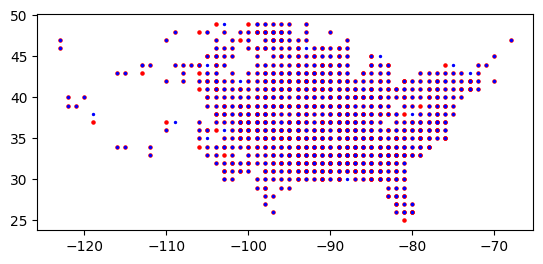

In [ ]:
import geopandas as gpd
from shapely.geometry import Point

# Convert the source and target coordinates to Point geometries
df_edges['Source'] = df_edges['Source'].apply(lambda x: convertTupleStrToTuple(x))
df_edges['Target'] = df_edges['Target'].apply(lambda x: convertTupleStrToTuple(x))

# Create GeoDataFrames for source and target points
gdf_source = gpd.GeoDataFrame(df_edges, geometry=gpd.points_from_xy(df_edges['Source'].apply(lambda x: x[1]), df_edges['Source'].apply(lambda x: x[0])))
gdf_target = gpd.GeoDataFrame(df_edges, geometry=gpd.points_from_xy(df_edges['Target'].apply(lambda x: x[1]), df_edges['Target'].apply(lambda x: x[0])))

# Plot the tornados on a map
ax = gdf_source.plot(color='red', markersize=5)
gdf_target.plot(ax=ax, color='blue', markersize=2)


In [ ]:
# Count the number of unique sources
num_unique_sources = df_edges['Source'].nunique()

# Count the number of unique targets
num_unique_targets = df_edges['Target'].nunique()

print("Number of unique sources:", num_unique_sources)
print("Number of unique targets:", num_unique_targets)


Number of unique sources: 529
Number of unique targets: 526


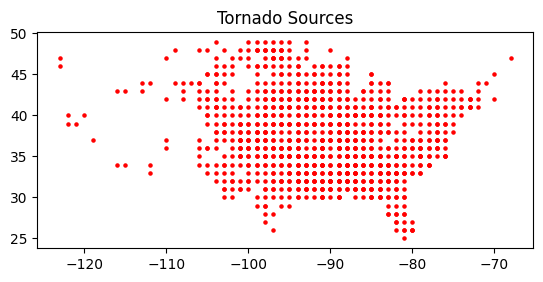

In [ ]:
# Convert the source coordinates to Point geometries
#df_edges['Source'] = df_edges['Source'].apply(lambda x: convertTupleStrToTuple(x))
gdf_source = gpd.GeoDataFrame(df_edges, geometry=gpd.points_from_xy(df_edges['Source'].apply(lambda x: x[1]), df_edges['Source'].apply(lambda x: x[0])))

# Plot the sources on a map
gdf_source.plot(color='red', markersize=5)
plt.title('Tornado Sources')
plt.show()

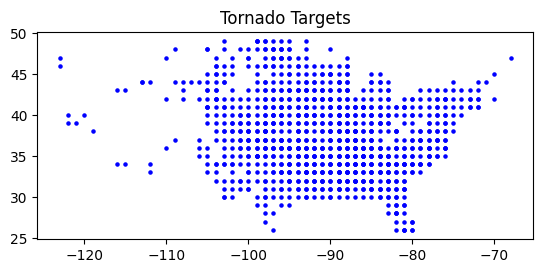

In [ ]:
gdf_target = gpd.GeoDataFrame(df_edges, geometry=gpd.points_from_xy(df_edges['Target'].apply(lambda x: x[1]), df_edges['Target'].apply(lambda x: x[0])))

# Plot the targets on a map
gdf_target.plot(color='blue', markersize=5)
plt.title('Tornado Targets')
plt.show()

# Community Detection

1. Louvain Algorithm: The Louvain algorithm is a fast and scalable algorithm for community detection. It optimizes modularity to identify communities in a network. It is known for its efficiency in handling large-scale networks.

2. Greedy modulaity Algorithm: The Greedy Modularity Algorithm is a popular algorithm used for community detection in networks. It aims to partition a network into communities by optimizing a quality function known as modularity. Modularity measures the strength of the division of a network into communities based on the density of connections within communities compared to the expected density if the network was random.

3. Girvan Newman: The Girvan-Newman Algorithm is another widely used method for community detection in networks. This algorithm takes a divisive approach, aiming to progressively remove edges from the network to break it down into communities. It is based on the concept of edge betweenness centrality.


We have tried several community detection algorithms like Louvaine and Girvan Newman and found out that the greedy modularity works the best in our data.

In [ ]:
from networkx.algorithms import community

# Perform community detection using the greedy modularity algorithm
communities = community.greedy_modularity_communities(G)

# Create a dictionary to map node IDs to community IDs
node_community_dict = dict()
for idx, comm in enumerate(communities):
  for node in comm:
    node_community_dict[convertTupleStrToTuple(node)] = idx

# Map community IDs to source and target nodes
df_edges['Source Community ID'] = df_edges['Source'].apply(lambda x: node_community_dict.get(x))
df_edges['Target Community ID'] = df_edges['Target'].apply(lambda x: node_community_dict.get(x))


In [ ]:
sort_dataframe(df_edges,'Number of Injuries').head()

,Edge,Source,Target,Tracked Length (KM),Number of Injuries,Number of Fatalities,EF Scale (AVG),Width in Meters (AVG),Edge Count,Edge Closeness,Edge Betweenness,Eigenvector,Edge Degree,Source State,Target State,Is Tornado Alley,Source Community ID,Target Community ID
9,"(33.0,-88.0) -> (34.0,-87.0)","(33.0, -88.0)","(34.0, -87.0)",129.84,1500,64,4.000000,2377.440000,1,0.013106,0.000598,5.536503e-09,17,Alabama,Alabama,True,0,0
406,"(37.0,-95.0) -> (37.0,-94.0)","(37.0, -95.0)","(37.0, -94.0)",69.31,1150,158,3.000000,682.753333,3,0.007616,0.000065,1.443822e-13,11,Kansas,Missouri,True,3,3
284,"(36.0,-89.0) -> (38.0,-87.0)","(36.0, -89.0)","(38.0, -87.0)",271.22,515,57,4.000000,2377.440000,1,0.016665,0.000685,2.583670e-04,14,Tennessee,Kentucky,False,5,5
607,"(33.0,-97.0) -> (33.0,-96.0)","(33.0, -97.0)","(33.0, -96.0)",30.28,468,10,2.500000,480.060000,2,0.003004,0.000007,1.551511e-17,8,Texas,Texas,True,21,21
336,"(35.0,-85.0) -> (35.0,-85.0)","(35.0, -85.0)","(35.0, -85.0)",271.16,379,37,1.733333,358.444667,15,0.016057,0.000000,5.298399e-08,12,Tennessee,Tennessee,True,0,0


By fitlering out the edges within the same community and keeping the edges between comunities just by looking at the top 20 rows of those edges, it appears that there's a connection between two close community IDs. Therefore we can assume that each two close community IDs (by value) can be merge to a single community or that they belong to a bigger cluster of nodes.

In [ ]:
# Create a new DataFrame with edges where Source Community ID is different from Target Community ID
different_community_edges = df_edges[df_edges['Source Community ID'] != df_edges['Target Community ID']].copy()

# Print the new DataFrame
different_community_edges.head(20)

,Edge,Source,Target,Tracked Length (KM),Number of Injuries,Number of Fatalities,EF Scale (AVG),Width in Meters (AVG),Edge Count,Edge Closeness,Edge Betweenness,Eigenvector,Edge Degree,Source State,Target State,Is Tornado Alley,Source Community ID,Target Community ID
29,"(36.0,-88.0) -> (37.0,-88.0)","(36.0, -88.0)","(37.0, -88.0)",9.08,0,0,1.000,91.440000,1,0.017101,0.000412,9.634108e-08,12,Kentucky,Kentucky,False,0,5
32,"(36.0,-87.0) -> (37.0,-87.0)","(36.0, -87.0)","(37.0, -87.0)",8.55,0,0,1.000,137.160000,1,0.020174,0.000810,1.765178e-07,14,Tennessee,Tennessee,True,0,5
50,"(32.0,-87.0) -> (32.0,-86.0)","(32.0, -87.0)","(32.0, -86.0)",36.37,0,0,1.000,274.320000,2,0.009867,0.000831,7.902699e-10,12,Alabama,Alabama,True,0,1
105,"(34.0,-94.0) -> (35.0,-94.0)","(34.0, -94.0)","(35.0, -94.0)",9.37,0,0,1.000,45.720000,1,0.006124,0.001037,2.891061e-13,12,Oklahoma,Oklahoma,True,2,3
116,"(32.0,-92.0) -> (32.0,-91.0)","(32.0, -92.0)","(32.0, -91.0)",45.08,1,0,2.000,804.670000,1,0.006986,0.001287,2.888205e-13,12,Louisiana,Louisiana,True,2,0
155,"(35.0,-94.0) -> (35.0,-93.0)","(35.0, -94.0)","(35.0, -93.0)",21.89,0,0,2.000,228.600000,1,0.008093,0.000927,8.668548e-13,13,Oklahoma,Arkansas,True,3,2
173,"(33.0,-87.0) -> (33.0,-86.0)","(33.0, -87.0)","(33.0, -86.0)",155.35,4,3,1.125,314.325000,8,0.011358,0.000338,3.161800e-09,11,Alabama,Alabama,True,0,1
181,"(31.0,-87.0) -> (32.0,-87.0)","(31.0, -87.0)","(32.0, -87.0)",7.29,1,0,1.000,45.720000,1,0.005093,0.000096,3.951711e-10,11,Florida,Alabama,True,1,0
236,"(38.0,-89.0) -> (39.0,-89.0)","(38.0, -89.0)","(39.0, -89.0)",7.66,0,0,1.000,91.440000,1,0.011314,0.001650,6.158999e-08,12,Illinois,Illinois,True,5,8
239,"(39.0,-85.0) -> (39.0,-84.0)","(39.0, -85.0)","(39.0, -84.0)",63.62,8,4,1.500,372.617500,4,0.018534,0.000477,6.847918e-04,9,Ohio,Ohio,False,5,13


Because we found out that there is a relationship between every two close community ID values, we can map each community id value to a number between 1 to 10 (our choice) by binning the community IDs. For our research it will be easier to work with 10 communities.

In [ ]:
# Identify the highest community id value
max_community_id = df_edges['Source Community ID'].max()
max_community_id

213

In [ ]:
bin_width = max_community_id / 10  # Calculate the bin width
df_edges['Source Community ID'] = (df_edges['Source Community ID'] / bin_width).apply(lambda x: int(round(x)))
df_edges['Target Community ID'] = (df_edges['Target Community ID'] / bin_width).apply(lambda x: int(round(x)))

In [ ]:
df_edges

,Edge,Source,Target,Tracked Length (KM),Number of Injuries,Number of Fatalities,EF Scale (AVG),Width in Meters (AVG),Edge Count,Edge Closeness,Edge Betweenness,Eigenvector,Edge Degree,Source State,Target State,Is Tornado Alley,Source Community ID,Target Community ID
0,"(33.0,-89.0) -> (33.0,-89.0)","(33.0, -89.0)","(33.0, -89.0)",461.38,92,13,1.194444,514.934167,36,0.012015,0.000000,7.922182e-10,12,Mississippi,Mississippi,True,0,0
1,"(33.0,-89.0) -> (33.0,-88.0)","(33.0, -89.0)","(33.0, -88.0)",343.76,14,1,2.000000,811.783333,9,0.011669,0.000746,1.582271e-09,16,Mississippi,Alabama,True,0,0
2,"(33.0,-89.0) -> (34.0,-89.0)","(33.0, -89.0)","(34.0, -89.0)",129.21,25,0,1.333333,624.840000,3,0.012891,0.000318,7.941661e-10,13,Mississippi,Mississippi,True,0,0
3,"(33.0,-90.0) -> (33.0,-89.0)","(33.0, -90.0)","(33.0, -89.0)",127.27,2,0,1.428571,949.668571,7,0.010340,0.000541,3.969753e-10,13,Mississippi,Mississippi,True,0,0
4,"(33.0,-90.0) -> (33.0,-90.0)","(33.0, -90.0)","(33.0, -90.0)",558.38,6,1,1.179487,591.405128,39,0.008666,0.000000,1.732353e-12,10,Mississippi,Mississippi,True,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
968,"(42.0,-87.0) -> (42.0,-87.0)","(42.0, -87.0)","(42.0, -87.0)",5.31,0,0,0.000000,137.160000,1,0.000000,0.000000,5.984973e-17,2,Indiana,Indiana,True,10,10
969,"(42.0,-85.0) -> (42.0,-85.0)","(42.0, -85.0)","(42.0, -85.0)",24.67,0,0,1.000000,251.460000,2,0.000000,0.000000,-4.061564e-17,2,Michigan,Michigan,False,10,10
970,"(48.0,-109.0) -> (48.0,-109.0)","(48.0, -109.0)","(48.0, -109.0)",7.87,0,0,-9.000000,27.430000,1,0.000000,0.000000,-2.602514e-17,2,Montana,Montana,False,10,10
971,"(46.0,-123.0) -> (46.0,-123.0)","(46.0, -123.0)","(46.0, -123.0)",6.28,0,0,0.000000,219.460000,1,0.000000,0.000000,-9.710961e-18,2,Washington,Washington,False,10,10


In [ ]:
output_df = sort_dataframe(df_edges,'Source Community ID')

In [ ]:
output_df.to_excel("output.xlsx")

In [ ]:
import folium
import pandas as pd

# Create a map centered on the US
map = folium.Map(location=[37, -95], zoom_start=4)

# Define colors for each community ID
community_colors = {
    0: 'red',
    1: 'blue',
    2: 'green',
    3: 'orange',
    4: 'black',
    5: 'white',
    6: 'purple',
    7: 'cyan',
    8: 'yellow',
    9: 'browm',
    10: 'gray'
}

# Add points for source locations with community colors
for index, row in df_edges.iterrows():
    source_coords = row['Source']
    source_community_id = row['Source Community ID']
    source_color = community_colors[source_community_id]
    folium.CircleMarker(
        location=source_coords,
        color=source_color,
        radius=5,
        fill=True,
        fill_color=source_color
    ).add_to(map)

# Add points for target locations with community colors
for index, row in df_edges.iterrows():
    target_coords = row['Target']
    target_community_id = row['Target Community ID']
    target_color = community_colors[target_community_id]
    folium.CircleMarker(
        location=target_coords,
        color=target_color,
        radius=5,
        fill=True,
        fill_color=target_color
    ).add_to(map)

# Display the map
map


When looking at the map, it is noticable that the largerst community is the red one, which matches the tornado valley countries. Besides, the 2nd largest community is the blue one, which wraps around those countries. In addition, the rest of the communities are getting more far away from the center of the valley, with less nodes.

In [ ]:
df_edges.corr()

,Tracked Length (KM),Number of Injuries,Number of Fatalities,EF Scale (AVG),Width in Meters (AVG),Edge Closeness,Edge Betweenness,Eigenvector,Edge Degree,Is Tornado Alley,Source Community ID,Target Community ID
Tracked Length (KM),1.000000,0.172113,0.186293,0.151041,0.213692,0.296786,-0.074570,-0.032008,0.287719,0.192161,-0.264891,-0.265177
Number of Injuries,0.172113,1.000000,0.805176,0.168905,0.302528,0.117291,0.032872,-0.005647,0.154974,0.058151,-0.074725,-0.074644
Number of Fatalities,0.186293,0.805176,1.000000,0.185719,0.305216,0.151973,0.053128,-0.009387,0.161001,0.022239,-0.078348,-0.078251
EF Scale (AVG),0.151041,0.168905,0.185719,1.000000,0.414109,0.218607,0.146782,0.020905,0.271570,0.101688,-0.253186,-0.253963
Width in Meters (AVG),0.213692,0.302528,0.305216,0.414109,1.000000,0.151792,0.194335,-0.018566,0.320747,0.112329,-0.174822,-0.174366
Edge Closeness,0.296786,0.117291,0.151973,0.218607,0.151792,1.000000,0.339145,0.186709,0.694604,0.192256,-0.511421,-0.510042
Edge Betweenness,-0.074570,0.032872,0.053128,0.146782,0.194335,0.339145,1.000000,-0.018811,0.460462,0.232400,-0.242564,-0.240426
Eigenvector,-0.032008,-0.005647,-0.009387,0.020905,-0.018566,0.186709,-0.018811,1.000000,0.030918,-0.093160,-0.043153,-0.043227
Edge Degree,0.287719,0.154974,0.161001,0.271570,0.320747,0.694604,0.460462,0.030918,1.000000,0.383614,-0.715892,-0.715560
Is Tornado Alley,0.192161,0.058151,0.022239,0.101688,0.112329,0.192256,0.232400,-0.093160,0.383614,1.000000,-0.350144,-0.351290


After analysing the output file, we noticed there could be a relation between the community ID number to the power of the tornado. After running the correlation df of the df_edges we noticed there is a negative correlation between the community ID (source and target) to the length of the tornado track (-0.28) as we expected. In addition, we noticed to a weak but noticable connection between the EF scale of the tornado to the community ID (-0.15).